## Ford Sentence Classification

Dataset Source: https://www.kaggle.com/datasets/gaveshjain/ford-sentence-classifiaction-dataset

##### Import Necessary Libraries

In [0]:
import pyspark

import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.ml import Pipeline

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

##### Ingest Dataset & Start Data Preprocessing

In [0]:
# File location and type
file_location = "/FileStore/tables/train_data.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

schema = StructType([
    StructField("_c0", IntegerType(), True),
    StructField("sentence_id", StringType(), True),
    StructField("new_sentence", StringType(), True),
    StructField("type", StringType(), True),
])

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .schema(schema)\
  .load(file_location)

df = df.drop("_c0", "sentence_id")

df = df.dropDuplicates()

df = df.dropna()

df = df.withColumn("sentence_len", F.size(F.split(F.col('new_sentence'), ' ')))

df = df.withColumnRenamed("new_sentence", "text")\
    .withColumnRenamed("type", "label")

display(df)

text,label,sentence_len
"Erarbeitung und Erstellung von Lten, Basic- und Detailengineering sowie Kostenplanung.",Responsibility,11
"Experience with anti-virus systems, backup & restore solutions, system management.",Skill,12
2+ years of experience using SQL and working with large data sets.,Experience,13
| Continually learn and adapt.,SoftSkill,6
"Technical Skills - Model N-Configuration Model N-Data model, PL/SQL Model N-Dataflow Model N-Direct Loader.",Skill,15
Grundlagenuntersuchungen zu verschiedenen statischen und volumetrischen Messtech-nologien zur Durchflussmessung von Gasen.,Responsibility,12
BS or equivalent.,Education,4
Relevant Experience (Years): 5-8 years.,Experience,6
"Bachelors Degree in Finance, Accounting or Economics.",Education,8
Ability to work in matrix environment and manage conflicting priorities .Self starter Take independent action and go beyond what the situation requires.,Requirement,24


Output can only be rendered in Databricks

Output can only be rendered in Databricks

##### Display Summary Statistics for Dataset

In [0]:
df.summary().show()

+-------+-------------------------------------+---------+------------------+
|summary|                                 text|    label|      sentence_len|
+-------+-------------------------------------+---------+------------------+
|  count|                                58010|    58010|             58010|
|   mean|                                 null|     null|13.428167557317703|
| stddev|                                 null|     null| 9.410887029044382|
|    min|                   *FRENCH SPEAKING*.|Education|                 1|
|    25%|                                 null|     null|                 8|
|    50%|                                 null|     null|                11|
|    75%|                                 null|     null|                17|
|    max|通过阶段性项目评审流程与领导团队沟...|SoftSkill|               744|
+-------+-------------------------------------+---------+------------------+



##### Remove Unnecessary Features

In [0]:
df = df.drop("sentence_len")

##### Display Distinct Label Values

In [0]:
df.select("label").distinct().show()

+--------------+
|         label|
+--------------+
|     Education|
|Responsibility|
|         Skill|
|   Requirement|
|    Experience|
|     SoftSkill|
+--------------+



##### Create Function to Remove Class Imbalance

In [0]:
def balance_dataset(dataset, unique_label_values, new_schema, samples = 20000, label_col = "label"):
    temp_df =  spark.createDataFrame([], new_schema)
    new_df =  spark.createDataFrame([], new_schema)
    
    for ulab in unique_label_values:
        # extract df of only the desired labels
        temp_df = dataset.where(F.col(label_col).isin(ulab))
        
        ratio = round(samples/temp_df.count(),4)
        # sample it to desired number of samples
        if ratio > 1.0:
            # Oversample
            temp_df = temp_df.sample(True, ratio, seed=42)
        elif ratio < 1.0:
            # Undersample
            temp_df = temp_df.sample(False, ratio, seed=42)
        elif ratio == 1.0:
            # Just use the existing dataframe
            pass
        # concatenate it to the new_df
        new_df = new_df.union(temp_df)
        # unpersist the temp_df
        temp_df.unpersist()
    return new_df

##### Define Necessary Values for Removing Dataset Imbalance & Run Function to do so

In [0]:
new_schema = StructType([
    StructField("text", StringType(), True),
    StructField("label", StringType(), True),
         ])

unique_label_vals = ["Education", "Responsibility", "Skill", "Requirement", "Experience", "SoftSkill"]

bal_ds = balance_dataset(df, unique_label_vals, new_schema, 10000, "label")

display(bal_ds)

text,label
Bachelors degree In Engineering preferably with Electrical/Electronics/Instrumentation background.,Education
Electrical or Electronics Associate Diploma or higher an advantage.,Education
Electrical or Electronics Associate Diploma or higher an advantage.,Education
This is a R&D Engineer/Scientist role for leading or supporting new product development and productivity improvement projects for Honeywells Advanced Materials.,Education
"Bachelors degree valued in Engineering (Building, Electrical, Mechanical, Industrial, etc).",Education
"YOU MUST HAVEBachelors degree in Engineering; Aerospace, Systems, Electrical or Mechanical.",Education
Hardware and/or Software quality design background. -,Education
Hardware and/or Software quality design background. -,Education
Hardware and/or Software quality design background. -,Education
IT degree is mandatory.,Education


##### Convert Labels from String to Integers

In [0]:
label_val_converter = {"Education" : "0", "Experience" : "1", "Requirement" : "2", "Responsibility" : "3", "Skill" : "4", "SoftSkill" : "5"}

bal_ds = bal_ds.replace(label_val_converter,subset=['label'])

display(bal_ds)

text,label
Bachelors degree In Engineering preferably with Electrical/Electronics/Instrumentation background.,0
Electrical or Electronics Associate Diploma or higher an advantage.,0
Electrical or Electronics Associate Diploma or higher an advantage.,0
This is a R&D Engineer/Scientist role for leading or supporting new product development and productivity improvement projects for Honeywells Advanced Materials.,0
"Bachelors degree valued in Engineering (Building, Electrical, Mechanical, Industrial, etc).",0
"YOU MUST HAVEBachelors degree in Engineering; Aerospace, Systems, Electrical or Mechanical.",0
Hardware and/or Software quality design background. -,0
Hardware and/or Software quality design background. -,0
Hardware and/or Software quality design background. -,0
IT degree is mandatory.,0


In [0]:
train_ds, test_ds = bal_ds.randomSplit(weights=[0.80, 0.20], seed=42)

print(f"# of Samples in Training Dataset: {train_ds.count()}")
print(f"# of Samples in Testing Dataset: {test_ds.count()}")

# of Samples in Training Dataset: 48470
# of Samples in Testing Dataset: 12198


##### Basic Values/Constants

In [0]:
NUM_OF_EPOCHS = 11
BATCH_SIZE = 64
LR = 3e-3
VERBOSITY_LEVEL = 2

##### Create Pipeline Stages

In [0]:
document_assembler = DocumentAssembler() \
    .setInputCol("text")\
    .setOutputCol("doc")
    
use = UniversalSentenceEncoder.pretrained()\
    .setInputCols(["doc"])\
    .setOutputCol("sent_embeds")

clf = ClassifierDLApproach()\
    .setInputCols(["sent_embeds"])\
    .setOutputCol("class")\
    .setLabelColumn("label")\
    .setBatchSize(BATCH_SIZE)\
    .setMaxEpochs(NUM_OF_EPOCHS)\
    .setLr(LR)\
    .setVerbose(VERBOSITY_LEVEL)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


##### Create Pipeline

In [0]:
ford_sent_pipe = Pipeline().setStages([
    document_assembler,
    use,
    clf
])

##### Fit/Train Model

In [0]:
clf_model = ford_sent_pipe.fit(train_ds)

##### Make Predictions Using Testing Dataset

In [0]:
preds = clf_model.transform(test_ds)

##### Condense to Only Return Necessary Features

In [0]:
preds_in_pandas = (preds.select(F.col('text').alias("text"), F.col('label').alias("ground_truth"), F.col('class.result').alias("prediction"))).toPandas()

##### Generate & Display Classification Report

In [0]:
preds_in_pandas['prediction'] = preds_in_pandas['prediction'].apply(lambda x : x[0])
 
report = classification_report(preds_in_pandas['ground_truth'], preds_in_pandas['prediction'])
 
print(report)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1997
           1       0.92      0.89      0.91      2048
           2       0.54      0.38      0.44      1974
           3       0.76      0.83      0.79      2080
           4       0.61      0.68      0.64      2022
           5       0.71      0.77      0.74      2077

    accuracy                           0.74     12198
   macro avg       0.73      0.73      0.73     12198
weighted avg       0.73      0.74      0.73     12198



##### Generate & Display Confusion Matrix

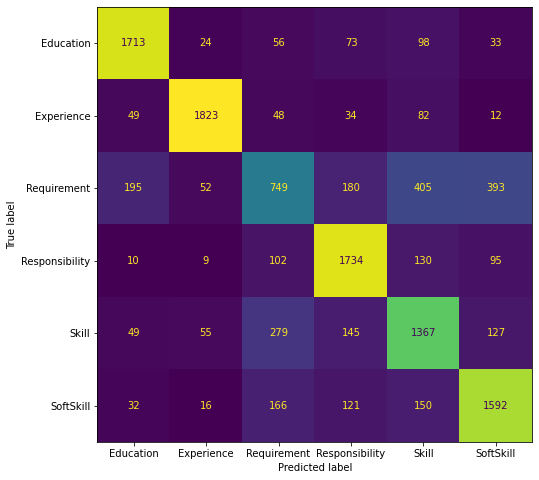

In [0]:
display_labels_converter = ["Education", "Experience", "Requirement", "Responsibility", "Skill", "SoftSkill"]

cm = confusion_matrix(preds_in_pandas['ground_truth'], preds_in_pandas['prediction'])
dist = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels_converter)

plt.rcParams['figure.figsize'] = [8, 8]
display(dist.plot(colorbar=False))

## Notes & Other Takeaways From This Project
****
- With the imbalance in the class ("label" column), I decided to go with 10,000 samples of each class as it was the nearest round number from averaging the unbalanced classes.
****
- Special thank you to both Databricks for having a Community Edition of their platform and John Snow Labs having an open-source version of their Spark NLP for me to use.
****
- The next step that I want to take is to include both the model, train/test split and metrics within the same pipeline as the preprocessing (document assembler, USE, and classifier).
****